In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader_pw import *
from cnn_model_1 import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'pairwise_lstm.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = PWDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

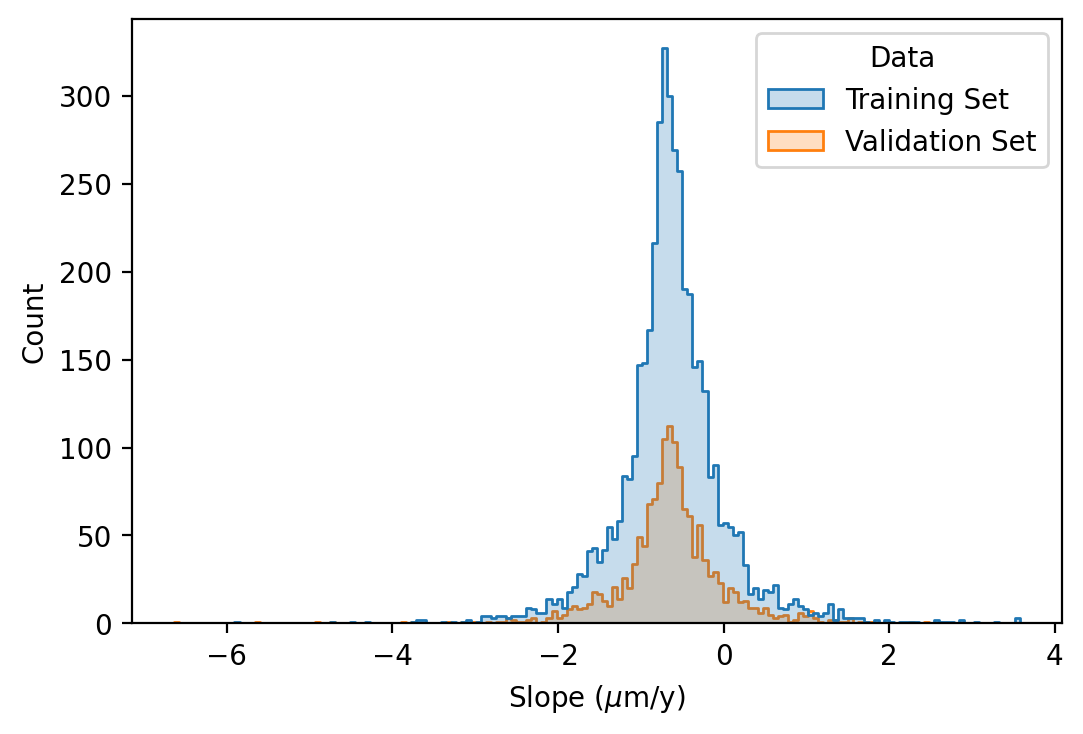

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

4445 1482


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

2


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'pw_statedict.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 70/70 [00:08<00:00,  7.80it/s, batch_loss=0.356, running_loss=30.5]


Train Loss: 30.5279 | Valid Loss: inf ===========> 10.4483 | Test Loss: 12.8618 | Saving model...


Epoch [2/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.954, running_loss=29.8]


Train Loss: 29.8230 | Valid Loss: 10.7597


Epoch [3/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.659, running_loss=29]


Train Loss: 28.9601 | Valid Loss: 10.6569


Epoch [4/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.22, running_loss=28.3]


Train Loss: 28.2866 | Valid Loss: 10.4483 ===========> 10.2936 | Test Loss: 11.8761 | Saving model...


Epoch [5/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.284, running_loss=27.1]


Train Loss: 27.1141 | Valid Loss: 10.2936 ===========> 9.8634 | Test Loss: 11.2369 | Saving model...


Epoch [6/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.18, running_loss=26.1]


Train Loss: 26.1278 | Valid Loss: 9.9769


Epoch [7/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.166, running_loss=25]


Train Loss: 24.9666 | Valid Loss: 9.8634 ===========> 9.2589 | Test Loss: 10.4577 | Saving model...


Epoch [8/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.183, running_loss=23.2]


Train Loss: 23.1890 | Valid Loss: 9.2589 ===========> 9.0192 | Test Loss: 10.0309 | Saving model...


Epoch [9/200]: 100%|██████████| 70/70 [00:08<00:00,  7.84it/s, batch_loss=0.592, running_loss=22.1]


Train Loss: 22.1089 | Valid Loss: 9.0192 ===========> 8.8754 | Test Loss: 9.6016 | Saving model...


Epoch [10/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.389, running_loss=21.7]


Train Loss: 21.7087 | Valid Loss: 10.2466


Epoch [11/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.225, running_loss=19.1]


Train Loss: 19.0725 | Valid Loss: 8.8754 ===========> 8.2889 | Test Loss: 9.1577 | Saving model...


Epoch [12/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.36, running_loss=17.8]


Train Loss: 17.8430 | Valid Loss: 8.2889 ===========> 7.9084 | Test Loss: 9.4665 | Saving model...


Epoch [13/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.123, running_loss=17.4]


Train Loss: 17.3691 | Valid Loss: 8.3474


Epoch [14/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.124, running_loss=16.3]


Train Loss: 16.2929 | Valid Loss: 8.4416


Epoch [15/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.176, running_loss=15.8]


Train Loss: 15.8312 | Valid Loss: 7.9084 ===========> 7.5537 | Test Loss: 7.8325 | Saving model...


Epoch [16/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.196, running_loss=14.9]


Train Loss: 14.8535 | Valid Loss: 8.9664


Epoch [17/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.218, running_loss=13.7]


Train Loss: 13.6705 | Valid Loss: 7.5537 ===========> 7.3453 | Test Loss: 7.4094 | Saving model...


Epoch [18/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.0985, running_loss=12.5]


Train Loss: 12.5150 | Valid Loss: 7.4130


Epoch [19/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.0955, running_loss=12.2]


Train Loss: 12.2324 | Valid Loss: 7.3453 ===========> 6.9798 | Test Loss: 7.1818 | Saving model...


Epoch [20/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.0946, running_loss=11]


Train Loss: 10.9622 | Valid Loss: 7.2122


Epoch [21/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.123, running_loss=11.2]


Train Loss: 11.2122 | Valid Loss: 7.3454


Epoch [22/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.098, running_loss=9.74]


Train Loss: 9.7449 | Valid Loss: 6.9798 ===========> 6.5387 | Test Loss: 6.9541 | Saving model...


Epoch [23/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.182, running_loss=9.52]


Train Loss: 9.5182 | Valid Loss: 8.1253


Epoch [24/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.112, running_loss=8.82]


Train Loss: 8.8151 | Valid Loss: 6.6784


Epoch [25/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.286, running_loss=8.26]


Train Loss: 8.2618 | Valid Loss: 6.5562


Epoch [26/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.109, running_loss=7.85]


Train Loss: 7.8532 | Valid Loss: 6.8502


Epoch [27/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.391, running_loss=7.93]


Train Loss: 7.9279 | Valid Loss: 10.6339


Epoch [28/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.113, running_loss=8.41]


Train Loss: 8.4061 | Valid Loss: 6.6636


Epoch [29/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0616, running_loss=6.59]


Train Loss: 6.5891 | Valid Loss: 6.5387 ===========> 6.5377 | Test Loss: 6.6499 | Saving model...


Epoch [30/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.116, running_loss=6.25]


Train Loss: 6.2546 | Valid Loss: 6.5377 ===========> 6.1631 | Test Loss: 6.9504 | Saving model...


Epoch [31/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.0453, running_loss=5.78]


Train Loss: 5.7838 | Valid Loss: 7.3621


Epoch [32/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.0714, running_loss=5.43]


Train Loss: 5.4310 | Valid Loss: 6.5389


Epoch [33/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0558, running_loss=5.31]


Train Loss: 5.3135 | Valid Loss: 6.1631 ===========> 6.1069 | Test Loss: 6.5332 | Saving model...


Epoch [34/200]: 100%|██████████| 70/70 [00:08<00:00,  7.83it/s, batch_loss=0.086, running_loss=5.25]


Train Loss: 5.2454 | Valid Loss: 6.1069 ===========> 5.7986 | Test Loss: 6.3482 | Saving model...


Epoch [35/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.0494, running_loss=4.87]


Train Loss: 4.8743 | Valid Loss: 6.0785


Epoch [36/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.0802, running_loss=4.64]


Train Loss: 4.6443 | Valid Loss: 6.4536


Epoch [37/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0634, running_loss=4.61]


Train Loss: 4.6090 | Valid Loss: 5.7986 ===========> 5.7195 | Test Loss: 6.1263 | Saving model...


Epoch [38/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.0624, running_loss=4.22]


Train Loss: 4.2246 | Valid Loss: 6.0336


Epoch [39/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.0728, running_loss=4.34]


Train Loss: 4.3383 | Valid Loss: 6.4896


Epoch [40/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.0393, running_loss=3.78]


Train Loss: 3.7771 | Valid Loss: 5.7571


Epoch [41/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0635, running_loss=3.84]


Train Loss: 3.8391 | Valid Loss: 6.5033


Epoch [42/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0789, running_loss=3.72]


Train Loss: 3.7213 | Valid Loss: 6.0725


Epoch [43/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.124, running_loss=3.59]


Train Loss: 3.5929 | Valid Loss: 6.6233


Epoch [44/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.0553, running_loss=3.58]


Train Loss: 3.5829 | Valid Loss: 5.7754


Epoch [45/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0552, running_loss=3.36]


Train Loss: 3.3590 | Valid Loss: 5.9652


Epoch [46/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.129, running_loss=3.29]


Train Loss: 3.2940 | Valid Loss: 7.2740


Epoch [47/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.0552, running_loss=3.24]


Train Loss: 3.2359 | Valid Loss: 6.1937


Epoch [48/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.0275, running_loss=3.14]


Train Loss: 3.1441 | Valid Loss: 7.3987


Epoch [49/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.0443, running_loss=2.83]


Train Loss: 2.8347 | Valid Loss: 5.8204


Epoch [50/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.0427, running_loss=3]


Train Loss: 2.9983 | Valid Loss: 6.3498


Epoch [51/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0591, running_loss=2.87]


Train Loss: 2.8729 | Valid Loss: 5.9335


Epoch [52/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.0433, running_loss=2.76]


Train Loss: 2.7607 | Valid Loss: 5.8517


Epoch [53/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.0493, running_loss=2.87]


Train Loss: 2.8689 | Valid Loss: 6.2986


Epoch [54/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0436, running_loss=2.71]


Train Loss: 2.7068 | Valid Loss: 5.7524


Epoch [55/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0118, running_loss=2.61]


Train Loss: 2.6057 | Valid Loss: 5.7195 ===========> 5.5622 | Test Loss: 6.1110 | Saving model...


Epoch [56/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0646, running_loss=2.68]


Train Loss: 2.6760 | Valid Loss: 6.4361


Epoch [57/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0362, running_loss=2.72]


Train Loss: 2.7170 | Valid Loss: 5.6312


Epoch [58/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.028, running_loss=2.59]


Train Loss: 2.5927 | Valid Loss: 5.5622 ===========> 5.5594 | Test Loss: 5.9997 | Saving model...


Epoch [59/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.0669, running_loss=2.65]


Train Loss: 2.6529 | Valid Loss: 5.6111


Epoch [60/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.0493, running_loss=2.53]


Train Loss: 2.5281 | Valid Loss: 6.3429


Epoch [61/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.0482, running_loss=2.58]


Train Loss: 2.5842 | Valid Loss: 5.5594 ===========> 5.5516 | Test Loss: 6.5431 | Saving model...


Epoch [62/200]: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s, batch_loss=0.0393, running_loss=2.44]


Train Loss: 2.4438 | Valid Loss: 6.0515


Epoch [63/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0291, running_loss=2.43]


Train Loss: 2.4319 | Valid Loss: 5.8521


Epoch [64/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0278, running_loss=2.4]


Train Loss: 2.3965 | Valid Loss: 6.0032


Epoch [65/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0223, running_loss=2.36]


Train Loss: 2.3601 | Valid Loss: 5.6091


Epoch [66/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.027, running_loss=2.35]


Train Loss: 2.3502 | Valid Loss: 5.5516 ===========> 5.5280 | Test Loss: 6.0158 | Saving model...


Epoch [67/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0265, running_loss=2.31]


Train Loss: 2.3081 | Valid Loss: 5.5957


Epoch [68/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.123, running_loss=2.38]


Train Loss: 2.3798 | Valid Loss: 5.5751


Epoch [69/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.0201, running_loss=2.27]


Train Loss: 2.2701 | Valid Loss: 5.7623


Epoch [70/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0186, running_loss=2.11]


Train Loss: 2.1137 | Valid Loss: 5.6674


Epoch [71/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0337, running_loss=2.19]


Train Loss: 2.1870 | Valid Loss: 6.0429


Epoch [72/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0265, running_loss=2.32]


Train Loss: 2.3207 | Valid Loss: 5.8429


Epoch [73/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0723, running_loss=2.16]


Train Loss: 2.1571 | Valid Loss: 6.0256


Epoch [74/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.037, running_loss=2.19]


Train Loss: 2.1926 | Valid Loss: 6.4504


Epoch [75/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0392, running_loss=2.22]


Train Loss: 2.2232 | Valid Loss: 5.8328


Epoch [76/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0294, running_loss=2.2]


Train Loss: 2.1991 | Valid Loss: 6.0095


Epoch [77/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0612, running_loss=2.26]


Train Loss: 2.2639 | Valid Loss: 5.7465


Epoch [78/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0402, running_loss=2.13]


Train Loss: 2.1344 | Valid Loss: 5.6823


Epoch [79/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0757, running_loss=2.13]


Train Loss: 2.1315 | Valid Loss: 5.7259


Epoch [80/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.026, running_loss=2.09]


Train Loss: 2.0943 | Valid Loss: 6.0649


Epoch [81/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0295, running_loss=2.12]


Train Loss: 2.1196 | Valid Loss: 5.6892


Epoch [82/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.018, running_loss=2]


Train Loss: 1.9956 | Valid Loss: 5.6114


Epoch [83/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0195, running_loss=2.04]


Train Loss: 2.0358 | Valid Loss: 5.9204


Epoch [84/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0299, running_loss=2.1]


Train Loss: 2.0979 | Valid Loss: 6.5871


Epoch [85/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0452, running_loss=2.01]


Train Loss: 2.0061 | Valid Loss: 6.2735


Epoch [86/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0404, running_loss=2.07]


Train Loss: 2.0682 | Valid Loss: 5.7327


Epoch [87/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0265, running_loss=2.03]


Train Loss: 2.0258 | Valid Loss: 6.7156


Epoch [88/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0484, running_loss=2.09]


Train Loss: 2.0942 | Valid Loss: 5.5280 ===========> 5.5123 | Test Loss: 6.2582 | Saving model...


Epoch [89/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0153, running_loss=2]


Train Loss: 2.0030 | Valid Loss: 5.7152


Epoch [90/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0147, running_loss=1.84]


Train Loss: 1.8443 | Valid Loss: 5.5973


Epoch [91/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0198, running_loss=1.86]


Train Loss: 1.8565 | Valid Loss: 5.8217


Epoch [92/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.017, running_loss=1.84]


Train Loss: 1.8375 | Valid Loss: 5.7950


Epoch [93/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0631, running_loss=1.92]


Train Loss: 1.9197 | Valid Loss: 6.0084


Epoch [94/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0501, running_loss=1.93]


Train Loss: 1.9308 | Valid Loss: 5.8162


Epoch [95/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0213, running_loss=1.83]


Train Loss: 1.8312 | Valid Loss: 5.8682


Epoch [96/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0195, running_loss=1.86]


Train Loss: 1.8621 | Valid Loss: 5.5960


Epoch [97/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0223, running_loss=1.92]


Train Loss: 1.9221 | Valid Loss: 5.6442


Epoch [98/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0155, running_loss=1.82]


Train Loss: 1.8188 | Valid Loss: 6.0419


Epoch [99/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0119, running_loss=1.91]


Train Loss: 1.9068 | Valid Loss: 5.6106


Epoch [100/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0382, running_loss=1.85]


Train Loss: 1.8510 | Valid Loss: 5.8158


Epoch [101/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0204, running_loss=1.83]


Train Loss: 1.8276 | Valid Loss: 5.7866


Epoch [102/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0235, running_loss=1.8]


Train Loss: 1.7997 | Valid Loss: 5.8509


Epoch [103/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0461, running_loss=1.84]


Train Loss: 1.8364 | Valid Loss: 5.5813


Epoch [104/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.041, running_loss=1.91]


Train Loss: 1.9086 | Valid Loss: 5.6079


Epoch [105/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0256, running_loss=1.87]


Train Loss: 1.8742 | Valid Loss: 5.6545


Epoch [106/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0209, running_loss=1.77]


Train Loss: 1.7736 | Valid Loss: 5.6284


Epoch [107/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.18, running_loss=1.8]


Train Loss: 1.7988 | Valid Loss: 5.8610


Epoch [108/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0163, running_loss=1.76]


Train Loss: 1.7563 | Valid Loss: 5.6172


Epoch [109/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0324, running_loss=1.68]


Train Loss: 1.6764 | Valid Loss: 5.9025


Epoch [110/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0137, running_loss=1.74]


Train Loss: 1.7354 | Valid Loss: 7.6290


Epoch [111/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0152, running_loss=1.8]


Train Loss: 1.7963 | Valid Loss: 5.8720


Epoch [112/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0379, running_loss=1.76]


Train Loss: 1.7588 | Valid Loss: 5.8771


Epoch [113/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.019, running_loss=1.69]


Train Loss: 1.6872 | Valid Loss: 5.5650


Epoch [114/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0208, running_loss=1.72]


Train Loss: 1.7176 | Valid Loss: 5.8815


Epoch [115/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0151, running_loss=1.72]


Train Loss: 1.7173 | Valid Loss: 5.7277


Epoch [116/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.00615, running_loss=1.73]


Train Loss: 1.7301 | Valid Loss: 5.7368


Epoch [117/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0185, running_loss=1.72]


Train Loss: 1.7204 | Valid Loss: 5.6224


Epoch [118/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0167, running_loss=1.7]


Train Loss: 1.7021 | Valid Loss: 5.6965


Epoch [119/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0138, running_loss=1.68]


Train Loss: 1.6778 | Valid Loss: 5.6931


Epoch [120/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0204, running_loss=1.67]


Train Loss: 1.6736 | Valid Loss: 5.6267


Epoch [121/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0155, running_loss=1.58]


Train Loss: 1.5761 | Valid Loss: 5.5768


Epoch [122/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0114, running_loss=1.57]


Train Loss: 1.5743 | Valid Loss: 5.7210


Epoch [123/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.02, running_loss=1.49]


Train Loss: 1.4860 | Valid Loss: 5.6439


Epoch [124/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0384, running_loss=1.5]


Train Loss: 1.4985 | Valid Loss: 6.0063


Epoch [125/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.0148, running_loss=1.52]


Train Loss: 1.5246 | Valid Loss: 5.7089


Epoch [126/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0155, running_loss=1.46]


Train Loss: 1.4613 | Valid Loss: 5.7333


Epoch [127/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0198, running_loss=1.55]


Train Loss: 1.5492 | Valid Loss: 5.6613


Epoch [128/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0113, running_loss=1.44]


Train Loss: 1.4401 | Valid Loss: 5.9716


Epoch [129/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.036, running_loss=1.46]


Train Loss: 1.4609 | Valid Loss: 5.7651


Epoch [130/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0107, running_loss=1.49]


Train Loss: 1.4872 | Valid Loss: 5.6829


Epoch [131/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0323, running_loss=1.48]


Train Loss: 1.4788 | Valid Loss: 5.5753


Epoch [132/200]: 100%|██████████| 70/70 [00:09<00:00,  7.50it/s, batch_loss=0.0264, running_loss=1.52]


Train Loss: 1.5241 | Valid Loss: 5.6033


Epoch [133/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0134, running_loss=1.5]


Train Loss: 1.4964 | Valid Loss: 5.7636


Epoch [134/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0188, running_loss=1.46]


Train Loss: 1.4647 | Valid Loss: 6.0488


Epoch [135/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.00862, running_loss=1.4]


Train Loss: 1.3973 | Valid Loss: 5.5922


Epoch [136/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.014, running_loss=1.46]


Train Loss: 1.4642 | Valid Loss: 6.3406


Epoch [137/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0185, running_loss=1.43]


Train Loss: 1.4262 | Valid Loss: 5.5942


Epoch [138/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0136, running_loss=1.44]


Train Loss: 1.4396 | Valid Loss: 5.7976


Epoch [139/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0175, running_loss=1.46]


Train Loss: 1.4622 | Valid Loss: 5.5937


Epoch [140/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0166, running_loss=1.47]


Train Loss: 1.4724 | Valid Loss: 5.7154


Epoch [141/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0121, running_loss=1.5]


Train Loss: 1.4965 | Valid Loss: 5.8629


Epoch [142/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0716, running_loss=1.49]


Train Loss: 1.4878 | Valid Loss: 5.6865


Epoch [143/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.0272, running_loss=1.45]


Train Loss: 1.4523 | Valid Loss: 5.6976


Epoch [144/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0273, running_loss=1.47]


Train Loss: 1.4708 | Valid Loss: 5.6071


Epoch [145/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.00996, running_loss=1.49]


Train Loss: 1.4935 | Valid Loss: 5.6127


Epoch [146/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0185, running_loss=1.42]


Train Loss: 1.4159 | Valid Loss: 5.6750


Epoch [147/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0124, running_loss=1.41]


Train Loss: 1.4128 | Valid Loss: 5.6443


Epoch [148/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0292, running_loss=1.44]


Train Loss: 1.4376 | Valid Loss: 5.6320


Epoch [149/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.012, running_loss=1.44]


Train Loss: 1.4383 | Valid Loss: 5.6047


Epoch [150/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0112, running_loss=1.43]


Train Loss: 1.4304 | Valid Loss: 5.5723


Epoch [151/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0359, running_loss=1.39]


Train Loss: 1.3900 | Valid Loss: 5.8391


Epoch [152/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0226, running_loss=1.42]


Train Loss: 1.4162 | Valid Loss: 6.0443


Epoch [153/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.024, running_loss=1.46]


Train Loss: 1.4562 | Valid Loss: 5.6273


Epoch [154/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0878, running_loss=1.5]


Train Loss: 1.4975 | Valid Loss: 5.5524


Epoch [155/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0454, running_loss=1.45]


Train Loss: 1.4460 | Valid Loss: 6.2059


Epoch [156/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0306, running_loss=1.48]


Train Loss: 1.4789 | Valid Loss: 5.6234


Epoch [157/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0216, running_loss=1.42]


Train Loss: 1.4176 | Valid Loss: 5.7376


Epoch [158/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0127, running_loss=1.43]


Train Loss: 1.4304 | Valid Loss: 5.5822


Epoch [159/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0266, running_loss=1.39]


Train Loss: 1.3911 | Valid Loss: 5.6520


Epoch [160/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0136, running_loss=1.48]


Train Loss: 1.4763 | Valid Loss: 5.5985


Epoch [161/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.00793, running_loss=1.44]


Train Loss: 1.4373 | Valid Loss: 5.6118


Epoch [162/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0108, running_loss=1.41]


Train Loss: 1.4150 | Valid Loss: 5.8934


Epoch [163/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.00982, running_loss=1.42]


Train Loss: 1.4200 | Valid Loss: 5.6640


Epoch [164/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0327, running_loss=1.39]


Train Loss: 1.3881 | Valid Loss: 5.9084


Epoch [165/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0102, running_loss=1.42]


Train Loss: 1.4207 | Valid Loss: 5.5560


Epoch [166/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.00977, running_loss=1.46]


Train Loss: 1.4646 | Valid Loss: 5.6823


Epoch [167/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.014, running_loss=1.46]


Train Loss: 1.4565 | Valid Loss: 5.6971


Epoch [168/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0162, running_loss=1.44]


Train Loss: 1.4356 | Valid Loss: 5.8328


Epoch [169/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0161, running_loss=1.39]


Train Loss: 1.3859 | Valid Loss: 6.1000


Epoch [170/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0169, running_loss=1.45]


Train Loss: 1.4499 | Valid Loss: 5.6091


Epoch [171/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0114, running_loss=1.39]


Train Loss: 1.3913 | Valid Loss: 5.5817


Epoch [172/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0176, running_loss=1.36]


Train Loss: 1.3608 | Valid Loss: 5.6502


Epoch [173/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0247, running_loss=1.43]


Train Loss: 1.4336 | Valid Loss: 5.7322


Epoch [174/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0178, running_loss=1.42]


Train Loss: 1.4222 | Valid Loss: 5.7376


Epoch [175/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0183, running_loss=1.44]


Train Loss: 1.4419 | Valid Loss: 6.5076


Epoch [176/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0113, running_loss=1.44]


Train Loss: 1.4352 | Valid Loss: 5.8059


Epoch [177/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0107, running_loss=1.47]


Train Loss: 1.4682 | Valid Loss: 5.5864


Epoch [178/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0152, running_loss=1.43]


Train Loss: 1.4315 | Valid Loss: 5.5429


Epoch [179/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0307, running_loss=1.42]


Train Loss: 1.4172 | Valid Loss: 5.7283


Epoch [180/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0205, running_loss=1.45]


Train Loss: 1.4512 | Valid Loss: 5.5558


Epoch [181/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.0197, running_loss=1.36]


Train Loss: 1.3601 | Valid Loss: 6.3223


Epoch [182/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0154, running_loss=1.45]


Train Loss: 1.4491 | Valid Loss: 5.6051


Epoch [183/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0131, running_loss=1.38]


Train Loss: 1.3752 | Valid Loss: 5.5922


Epoch [184/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0266, running_loss=1.41]


Train Loss: 1.4095 | Valid Loss: 6.0382


Epoch [185/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0108, running_loss=1.43]


Train Loss: 1.4291 | Valid Loss: 5.5901


Epoch [186/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0144, running_loss=1.45]


Train Loss: 1.4450 | Valid Loss: 5.5631


Epoch [187/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.00905, running_loss=1.39]


Train Loss: 1.3931 | Valid Loss: 5.5802


Epoch [188/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0147, running_loss=1.41]


Train Loss: 1.4068 | Valid Loss: 5.6831


Epoch [189/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0186, running_loss=1.38]


Train Loss: 1.3817 | Valid Loss: 6.0293


Epoch [190/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0323, running_loss=1.44]


Train Loss: 1.4367 | Valid Loss: 5.8257


Epoch [191/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0124, running_loss=1.4]


Train Loss: 1.3972 | Valid Loss: 5.6901


Epoch [192/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0131, running_loss=1.4]


Train Loss: 1.3989 | Valid Loss: 5.6050


Epoch [193/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0379, running_loss=1.41]


Train Loss: 1.4129 | Valid Loss: 5.6354


Epoch [194/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0226, running_loss=1.42]


Train Loss: 1.4239 | Valid Loss: 5.5596


Epoch [195/200]: 100%|██████████| 70/70 [00:09<00:00,  7.56it/s, batch_loss=0.0122, running_loss=1.4]


Train Loss: 1.4002 | Valid Loss: 5.6295


Epoch [196/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0204, running_loss=1.34]


Train Loss: 1.3443 | Valid Loss: 5.5722


Epoch [197/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.013, running_loss=1.42]


Train Loss: 1.4197 | Valid Loss: 6.5533


Epoch [198/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0144, running_loss=1.41]


Train Loss: 1.4117 | Valid Loss: 6.8635


Epoch [199/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0163, running_loss=1.44]


Train Loss: 1.4361 | Valid Loss: 5.6031


Epoch [200/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.014, running_loss=1.39]


Train Loss: 1.3852 | Valid Loss: 5.5863


Train Loss: 2.0942 | Valid Loss: 5.5123 | Test Loss on Best Model: 6.2582


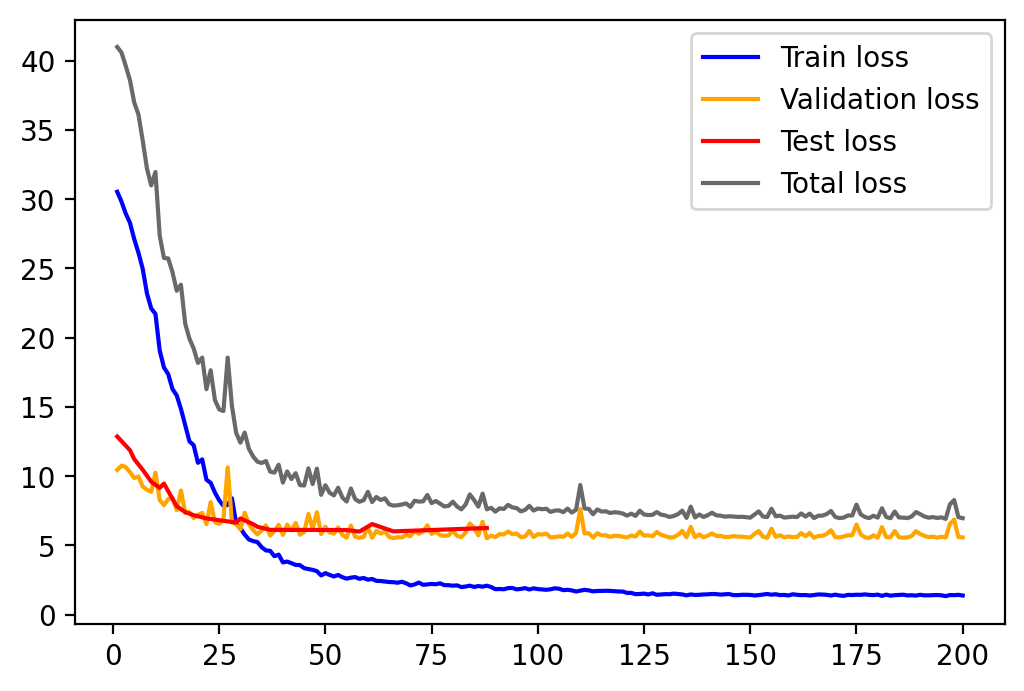

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('pw_statedict.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


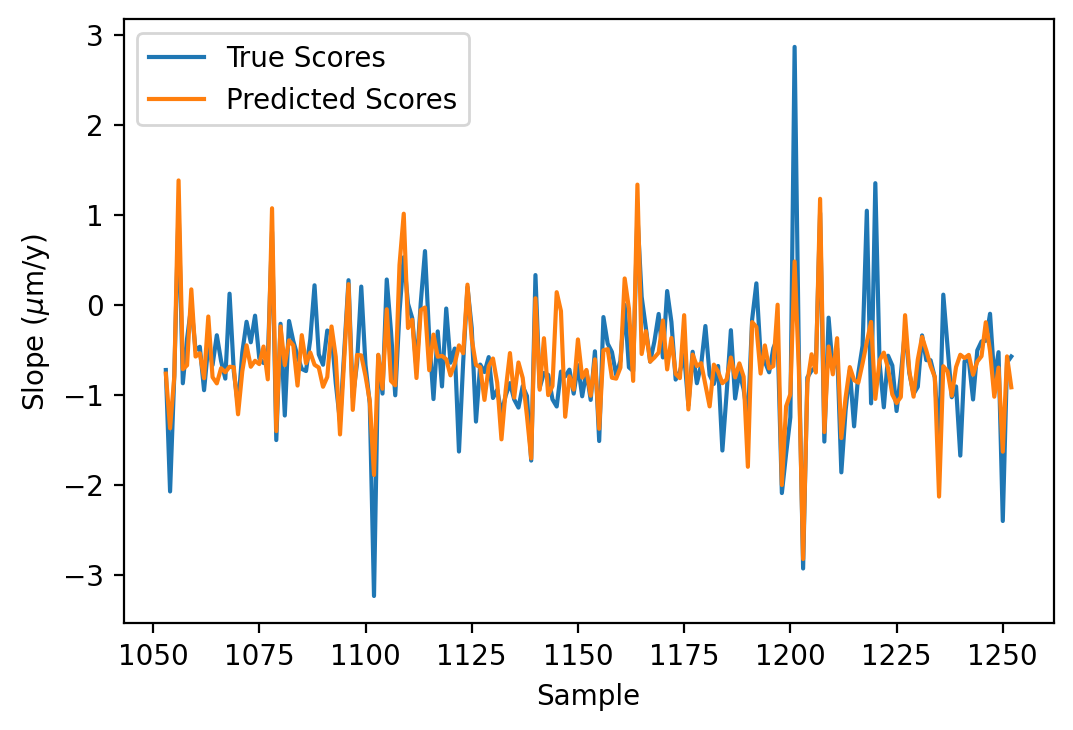

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

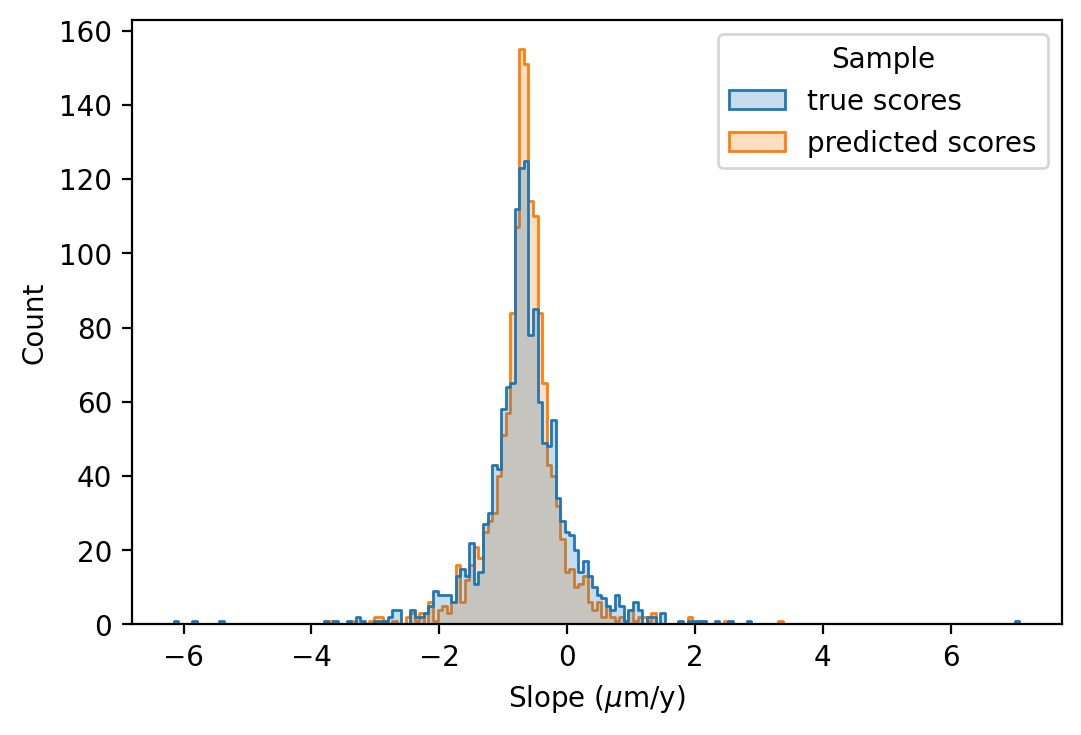

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
import pandas as pd
import numpy as np
df.to_csv('predscores.csv')
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)
print(coefficient_of_dermination)


0.5321739035777351


In [13]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [14]:
rsquared(true, pred)

0.5329350221125481

In [15]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6724596870652978, pvalue=1.1690271662416137e-195)

In [16]:
scipy.stats.pearsonr(true, pred)

(0.7300239873542155, 6.199361434445599e-247)